<a href="https://colab.research.google.com/github/koyomin9zx/CS114.K21-Machine-Learning/blob/master/Case_Study_1_Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preprocessing**

In [0]:
#Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
#upload kaggle API
uploaded = files.upload()

In [0]:
#import data from kaggle to colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

In [0]:
#unzip dataset
!unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

In [59]:
#read dataset
import pandas as pd

df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [58]:
#See how our headlines look like
for i,headline in enumerate (df['headline'], 1):
    if i > 20:
        break
    else:
        print(i, headline)

1 thirtysomething scientists unveil doomsday clock of hair loss
2 dem rep. totally nails why congress is falling short on gender, racial equality
3 eat your veggies: 9 deliciously different recipes
4 inclement weather prevents liar from getting to work
5 mother comes pretty close to using word 'streaming' correctly
6 my white inheritance
7 5 ways to file your taxes with less stress
8 richard branson's global-warming donation nearly as much as cost of failed balloon trips
9 shadow government getting too large to meet in marriott conference room b
10 lots of parents know this scenario
11 this lesbian is considered a father in indiana (and an amazing one at that)
12 amanda peet told her daughter sex is 'a special hug'
13 what to know regarding current treatments for ebola
14 chris christie suggests hillary clinton was to blame for boko haram's kidnapping of hundreds of schoolgirls
15 ford develops new suv that runs purely on gasoline
16 uber ceo travis kalanick stepping down from trump ec

***text cleansing***

In [60]:
import string
from string import digits, punctuation

hl_cleansed = []
for hl in df['headline']:
    #     Remove punctuations
    clean = hl.translate(str.maketrans('', '', punctuation))
    #     Remove digits/numbers
    clean = clean.translate(str.maketrans('', '', digits))
    hl_cleansed.append(clean)
    
# View comparison
print('Original texts :')
print(df['headline'][2])
print('\nAfter cleansed :')
print(hl_cleansed[2])

Original texts :
eat your veggies: 9 deliciously different recipes

After cleansed :
eat your veggies  deliciously different recipes


***Tokenization***

In [61]:
# Tokenization process
hl_tokens = []
for hl in hl_cleansed:
    hl_tokens.append(hl.split())

# View Comparison
print('Before tokenization :')
print(hl_cleansed[100])
print('\nAfter tokenization :')
print(hl_tokens[100])

Before tokenization :
report  of trump endorsements made after staring at bedroom ceiling for  hours

After tokenization :
['report', 'of', 'trump', 'endorsements', 'made', 'after', 'staring', 'at', 'bedroom', 'ceiling', 'for', 'hours']


***Lemmatization***

In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

In [63]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

hl_lemmatized = []
for tokens in hl_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    hl_lemmatized.append(lemm)
    
# Example comparison
word_1 = ['skyrim','dragons', 'are', 'having', 'parties']
word_2 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_1]
print('Before lemmatization :\t',word_1)
print('After lemmatization :\t',word_2)

Before lemmatization :	 ['skyrim', 'dragons', 'are', 'having', 'parties']
After lemmatization :	 ['skyrim', 'dragon', 'be', 'have', 'party']


# ***Training LSTM Model***

Preparing the Data

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Vectorize and convert text into sequences
max_features = 2000
max_token = len(max(hl_lemmatized))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_lemmatized)
sequences = tokenizer.texts_to_sequences(hl_lemmatized)
X = pad_sequences(sequences, maxlen=max_token)

Split Train, test

In [0]:
from sklearn.model_selection import train_test_split

Y = df['is_sarcastic'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

Building the Model

In [78]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embed_dim = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 14, 64)            128000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 97        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 189,921
Trainable params: 189,921
Non-trainable params: 0
_________________________________________________________________
None


Training process

In [79]:
epoch = 20
batch_size = 128
history=model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16026 samples, validate on 4007 samples
Epoch 1/20
 - 4s - loss: 0.5558 - accuracy: 0.6937 - val_loss: 0.4320 - val_accuracy: 0.8151
Epoch 2/20
 - 4s - loss: 0.3746 - accuracy: 0.8412 - val_loss: 0.3898 - val_accuracy: 0.8238
Epoch 3/20
 - 4s - loss: 0.3313 - accuracy: 0.8575 - val_loss: 0.3851 - val_accuracy: 0.8303
Epoch 4/20
 - 4s - loss: 0.3101 - accuracy: 0.8692 - val_loss: 0.3823 - val_accuracy: 0.8281
Epoch 5/20
 - 4s - loss: 0.2912 - accuracy: 0.8758 - val_loss: 0.3924 - val_accuracy: 0.8271
Epoch 6/20
 - 4s - loss: 0.2758 - accuracy: 0.8829 - val_loss: 0.4081 - val_accuracy: 0.8263
Epoch 7/20
 - 4s - loss: 0.2577 - accuracy: 0.8929 - val_loss: 0.4016 - val_accuracy: 0.8256
Epoch 8/20
 - 4s - loss: 0.2444 - accuracy: 0.8995 - val_loss: 0.4293 - val_accuracy: 0.8213
Epoch 9/20
 - 4s - loss: 0.2350 - accuracy: 0.9047 - val_loss: 0.4479 - val_accuracy: 0.8173
Epoch 10/20
 - 4s - loss: 0.2259 - accuracy: 0.9077 - val_loss: 0.4643 - val_accuracy: 0.8206
Epoch 11/20
 - 4s - 

# ***Model Evaluation***

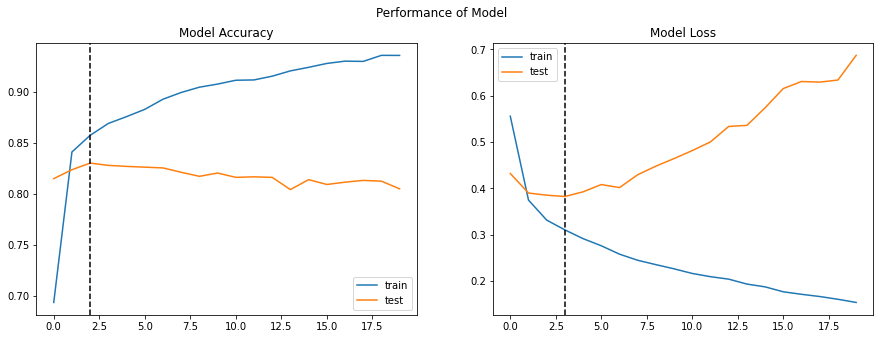

In [80]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

# ***Test The Model***

In [81]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.around(result) == np.around(Y_test[x]):
        if np.around(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.around(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("Sarcasm accuracy\t: ", round(pos_correct/pos_cnt*100, 3),"%")
print("Non-sarcasm accuracy\t: ", round(neg_correct/neg_cnt*100, 3),"%")

Sarcasm accuracy	:  77.511 %
Non-sarcasm accuracy	:  82.604 %


# **Use Another ML Algorithms to Classify**

Preparing the Data

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [0]:
X = [" ".join(x) for x in hl_lemmatized]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['is_sarcastic'],test_size=0.3)

Word Vectorization using TF-IDF

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

***Trainning on the SVM classifier***

In [90]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

Predict and evaluate the SVM classifier

In [91]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  83.13533659445609


***Trainning on the Naive Bayes Classifier***

In [93]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predict and evaluate the Naive Bayes Classifier

In [94]:
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  82.80922431865828
